## 10. Практика. Статистические тесты в контексте EDA
### ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА
_Штонда А.С._  

#### 0. Постановка проблемы

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

2. Ответить на ключевые вопросы HR-агентства:
* Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
* Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
* Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
* Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
3. Найти в данных другие интересные закономерности.

#### 1. Загрузка и обработка данных

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

Исходный файл с данными 'ds_salaries.csv' сосхранен в облаке по ссылке:  
https://drive.google.com/file/d/1FwCryy3hCQI_65B099t0qQk85vDyXZpF/view?usp=sharing

In [79]:
# cоздаем dataframe, визуализируем данные
df = pd.read_csv('data/ds_salaries.csv')
display(df.head(3), df.tail(3))

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M


,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M
606,606,2022,MI,FT,AI Scientist,200000,USD,200000,IN,100,US,L


In [80]:
# выводим информацию о признаках (наличие пустых значений, типы данных)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB
None


In [81]:
# выводим количество уникальных значений по признакам
print('\n', df.nunique())


 Unnamed: 0            607
work_year               3
experience_level        4
employment_type         4
job_title              50
salary                272
salary_currency        17
salary_in_usd         369
employee_residence     57
remote_ratio            3
company_location       50
company_size            3
dtype: int64


* _Комментарий_  
Данные корректно загружены.  
В таблице 607 записей, ни в одной нет пустых значений.  
Признак 'Unnamed: 0' можно удалять как содержащий неинформативные индексы.  
Признаки 'salary' и 'salary_currency' можно удалять, поскольку они преобразованы в 'salary_in_usd'.  
Числовым является только один признак 'salary_in_usd' - его тип указан корректно.  
Остальные признаки по сути являются категориальными (можно преобразовать)

In [82]:
# удаляем неинформативные признаки
df_droped = df.drop(['Unnamed: 0', 'salary', 'salary_currency'], axis=1)

# удаеляем полные дубликаты записей
print('Количество дубликатов: {}'.format(df_droped[df_droped.duplicated()].shape[0]))
df_droped = df_droped.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}\n'.format(df_droped.shape))

# устанавливаем для категориальных признаков корректный тип
df_dTyped = df_droped.astype('category')
df_dTyped['salary_in_usd'] = df_droped['salary_in_usd'].astype('int64')
df_dTyped.info()

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           565 non-null    category
 1   experience_level    565 non-null    category
 2   employment_type     565 non-null    category
 3   job_title           565 non-null    category
 4   salary_in_usd       565 non-null    int64   
 5   employee_residence  565 non-null    category
 6   remote_ratio        565 non-null    category
 7   company_location    565 non-null    category
 8   company_size        565 non-null    category
dtypes: category(8), int64(1)
memory usage: 21.4 KB


* _Комментарий_  
Удалено три неинформативных признака, которые точно не будут учавствовать в исследовании.  
Удалено 42 дублирующие записи.  
В итоге остался только один числовой признак 'salary_in_usd'. Остальные - категориальные.  
Часть категориальных признаков ('job_title', 'employee_residence', 'company_location') содержат более 50 уникальных значений и, возможно, потребуют некоторых преобразований далее

In [83]:
# выводим основные статистические характеристики для числового признака

display(df_dTyped.describe())

,salary_in_usd
count,565.000000
mean,110610.343363
std,72280.702792
min,2859.000000
25%,60757.000000
50%,100000.000000
75%,150000.000000
max,600000.000000


In [84]:
# выводим основные статистические характеристики для категориальных признаков

df_dTyped.describe(include=['category'])

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
count,565,565,565,565,565,565,565,565
unique,3,4,4,50,57,3,50,3
top,2022,SE,FT,Data Scientist,US,100,US,M
freq,278,243,546,130,295,346,318,290


**Итоги по п. 1**  
Загружены и подготовлены для дальнейшей работы данные HR агенства.  
После очистки и преобразования типов остался один числовой (зарпалата в долларах) и 8 категориальных признаков.  
Согласно предварительной статистике есть отличия между средней и медианными зарплатами, что говорит о не нормальном распределении или выбросах. Наибольшее количество записей относится к роли Data Scientist, к 2022 году, к компаниям из США, среднего размера, в основном полного дня и удаленной работы. 

#### 2. Разведывательный анализ данных  
##### 2.1. Визуальный анализ данных

In [85]:
# Проверяем формы записи

print(df_dTyped['job_title'].value_counts())

job_title
Data Scientist                              130
Data Engineer                               121
Data Analyst                                 82
Machine Learning Engineer                    39
Research Scientist                           16
Data Science Manager                         12
Data Architect                               11
Big Data Engineer                             8
Machine Learning Scientist                    8
Director of Data Science                      7
Data Analytics Manager                        7
AI Scientist                                  7
Principal Data Scientist                      7
Data Science Consultant                       7
Lead Data Engineer                            6
ML Engineer                                   6
Computer Vision Engineer                      6
BI Data Analyst                               6
Head of Data                                  5
Data Engineering Manager                      5
Business Data Analyst         

* _Комментарий_  
Записи названий ролей в форме 'Data Scientist' и 'Data Engineer' преобладают. Остальные роли не будут учитываться как значимые. Фильтрация данных будет осуществлена только для форм названий 'Data Scientist' и 'Data Engineer'

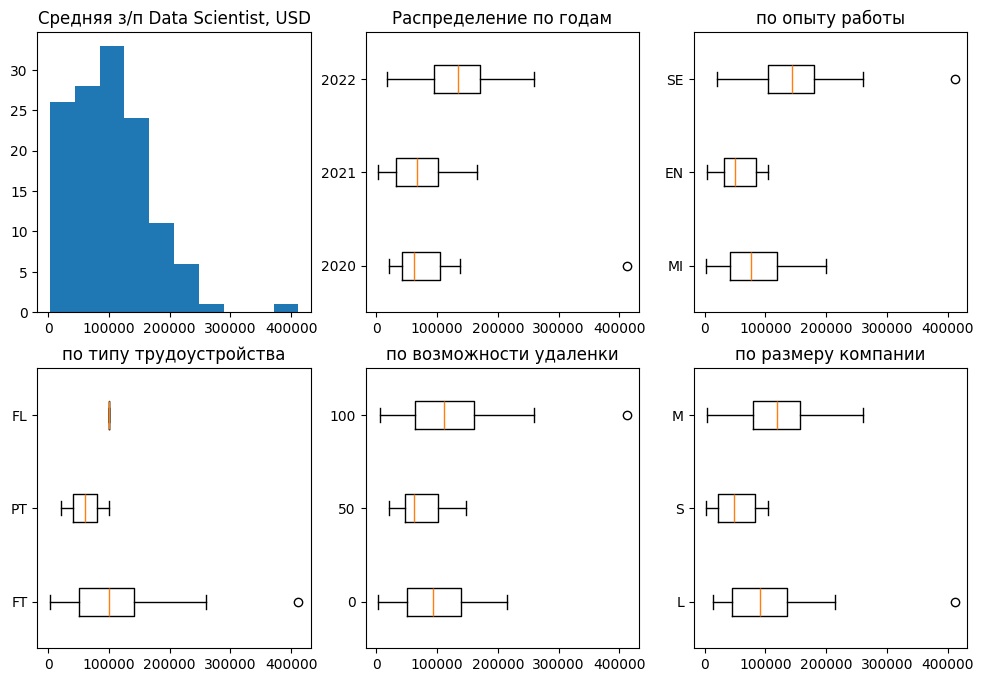

In [86]:
# Визуализируем влияние всех возможных факторов на зарплаты Data Scientist

# Для факторов с малым количеством категорий - коробчатые диаграммы

# Функция для подготовки данных для отражения на графиках
def salary_in_usd (col, df):
    labels = df[col].unique()
    data = []
    for elem in labels:
        data.append(list(df[df[col]==elem]['salary_in_usd']))
    return labels, data

df_DS = df_dTyped[df_dTyped['job_title']=='Data Scientist']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Распределение средней з/п Data Scientist (DS)
axes[0, 0].hist(x=df_DS['salary_in_usd'], bins=10)
axes[0, 0].set_title("Средняя з/п Data Scientist, USD")

# Распределение з/п DS по годам
labels, data = salary_in_usd ('work_year', df_DS)
axes[0, 1].boxplot(x=data, vert=False, labels=labels)
axes[0, 1].set_title("Распределение по годам")

# Распределение з/п DS по опыту работы
labels, data = salary_in_usd ('experience_level', df_DS)
axes[0, 2].boxplot(x=data, vert=False, labels=labels)
axes[0, 2].set_title("по опыту работы")

# Распределение з/п DS по типу трудоустройствва
labels, data = salary_in_usd ('employment_type', df_DS)
axes[1, 0].boxplot(x=data, vert=False, labels=labels)
axes[1, 0].set_title("по типу трудоустройства")

# Распределение з/п DS по возможности удаленки
labels, data = salary_in_usd ('remote_ratio', df_DS)
axes[1, 1].boxplot(x=data, vert=False, labels=labels)
axes[1, 1].set_title("по возможности удаленки")

# Распределение з/п DS по размеру компании
labels, data = salary_in_usd ('company_size', df_DS)
axes[1, 2].boxplot(x=data, vert=False, labels=labels)
axes[1, 2].set_title("по размеру компании");

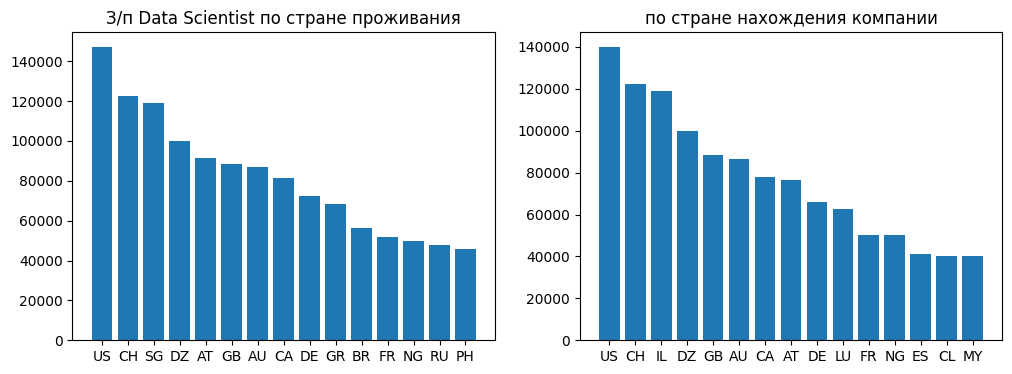

In [87]:
# Для факторов с большим количеством категорий строим столбчатые диаграммы

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Распределение по стране проживания сотрудника
data_empl = df_DS.groupby(['employee_residence'],
        observed=True)['salary_in_usd'].mean().nlargest(15)
axes[0].bar(x = data_empl.index, height = data_empl)
axes[0].set_title("З/п Data Scientist по стране проживания")

# Распределение по месту нахождения компании
data_comp = df_DS.groupby(['company_location'],
        observed=True)['salary_in_usd'].mean().nlargest(15)
axes[1].bar(x = data_comp.index, height = data_comp)
axes[1].set_title("по стране нахождения компании");

* _Комментарий_  
Все семь факторов (_год работы, опыт работы, тип трудоустройства, возможность удаленки, размер компании, страна проживания, страна компании_) визуально влияют на величину средней зарплаты Data Scientist

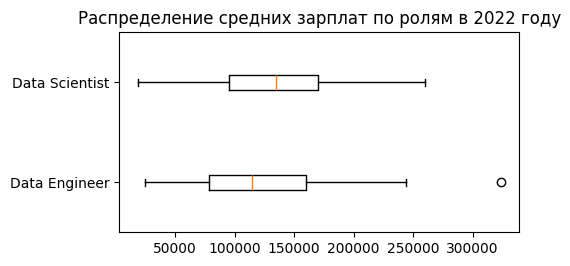

In [88]:
#  Сравниваем зарплаты Data Scientist и Data Engineer в 2022 году

df_DS_DE_2022 = df_dTyped[(
    (df_dTyped['job_title']=='Data Scientist') | (
    df_dTyped['job_title']=='Data Engineer')
            ) & (df_dTyped['work_year']==2022)]

labels, data = salary_in_usd ('job_title', df_DS_DE_2022)

fig = plt.figure(figsize=(4, 2))
axes = fig.add_axes([0, 0, 1, 1])

axes.boxplot(x=data, vert=False, labels=labels)
axes.set_title("Распределение средних зарплат по ролям в 2022 году");

count  count_sum  percent
company_size job_category                             
L            Data Engineer      34        193     18.0
             Data Scientist     43        193     22.0
             Other             116        193     60.0
M            Data Engineer      81        290     28.0
             Data Scientist     66        290     23.0
             Other             143        290     49.0
S            Data Engineer       6         82      7.0
             Data Scientist     21         82     26.0
             Other              55         82     67.0

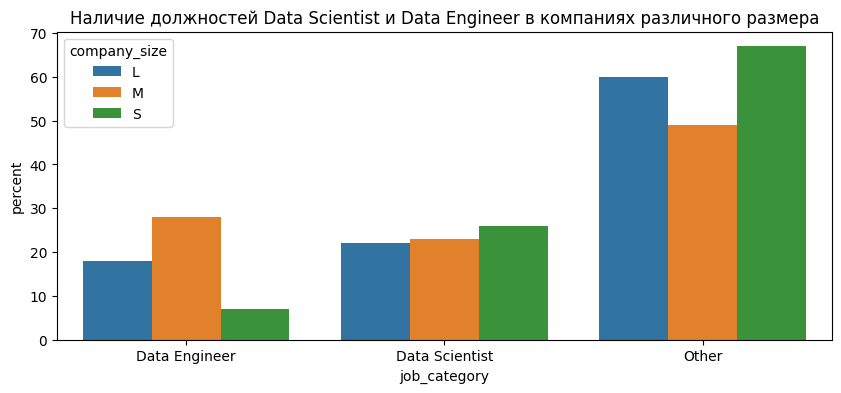

In [89]:
# Определяем процент Data Scientist и Data Engineer среди компаний разного размера

DS_DE_df = df_dTyped[['company_size', 'job_title']].copy()
DS_DE_df['job_category'] = DS_DE_df['job_title'].apply(
    lambda x: x if x == 'Data Scientist' or x == 'Data Engineer' else 'Other'
    )
DS_DE_df['count'] = 1
DS_DE_count = DS_DE_df[['company_size', 'job_category', 'count']].groupby(['company_size', 'job_category'], observed=False).sum()
DS_DE_sum = DS_DE_df[['company_size', 'count']].groupby(['company_size'], observed=False).sum()
DS_DE_percent = DS_DE_count.join(DS_DE_sum, rsuffix='_sum', on='company_size')
DS_DE_percent['percent'] = round(DS_DE_percent['count'] / DS_DE_percent['count_sum'] * 100, 0)

display(DS_DE_percent)


# визуализируем на столбчатом графике
# 
fig = plt.figure(figsize=(10, 4))

barplot = sns.barplot(
    data=DS_DE_percent,
    x='job_category',
    y='percent',
    hue='company_size'
)
barplot.set_title('Наличие должностей Data Scientist и Data Engineer в компаниях различного размера');


**Итоги по п. 2.1**  
Согласно визуальной оценки данных все восемь изученных факторов (год работы, опыт работы, тип трудоустройства, возможность удаленки, размер компании, страна проживания, страна компании) влияют на среднюю зарплату Data Scientist.
По построенным графикам можно дать такие предварительные ответы на на ключевые вопросы HR-агентства:
* Каждый год наблюдается рост зарплат у специалистов Data Scientist. Если сравнивать с 2020 и 2021 годами, то в 2022 этот рост наиболее выражен.
* В 2022 году у Data Scientist наблюдались более высокие зарплаты (не несколько десятков тысяч выше), чем у Data Engineer.
* Наиболее высокие зарплаты специалистов Data Scientist в компаниях среднего размера. При чем ее величина лишь немного больше в более крупных компаниях и на много превышает зарплаты мелких компаний. Это может быть связано с тем, что не все мелкие компании способны дать достойную зараплату для специалистов высокого уровня, а в крупных компаниях больше конкуренция.
* Наличие должностей Data Scientist и Data Engineer в основном свойственно средним и более крупным компаниями. Видимо более мелкие компании в силу небольшого штата обходятся либо универсальными специалистами, либо одной из представленных ролей.


##### 2.2. Статистический анализ данных

In [90]:
# задаём уровень значимости
alpha = 0.05 

# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))

# функция для решения о равенстве дисперсий
def decision_dispersies(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
    else:
        print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')
 

# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

**Наблюдается ли ежегодный рост зарплат у специалистов _Data Scientist_?**

*Нулевая гипотеза* ($H_0$): Средняя зарплата специалиста _Data Scientist_ в 2022 г. ($μ_1$) статистически меньше либо равна зарплате _Data Scientist_ в 2021 г. ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): Средняя зарплата специалиста _Data Scientist_ в 2022 г. ($μ_1$) статистически больше, чем зарплата _Data Scientist_ в 2021 г. ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

In [91]:
# значения зарплат Data Scientist по годам
df_DS_2022 = df_DS.loc[df_DS['work_year']==2022, 'salary_in_usd']
df_DS_2021 = df_DS.loc[df_DS['work_year']==2021, 'salary_in_usd']

# проводим тест Шапиро — Уилка на нормальность
print('Тест на нормальность:', '\nДля 2022 г.:')
result = stats.shapiro(df_DS_2022)
decision_normality(result[1])

print('Для 2021 г.:')
result = stats.shapiro(df_DS_2021)
decision_normality(result[1])


# проводим тест Левена на равенство дисперсий
print('\nТест на равенство дисперсий (для нормально распределенных данных)')
result = stats.levene(df_DS_2022, df_DS_2021)
decision_dispersies(result[1])


# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
result = stats.ttest_ind(df_DS_2022, df_DS_2021, alternative='greater', equal_var=True)
decision_hypothesis(result[1])

Тест на нормальность: 
Для 2022 г.:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2021 г.:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Тест на равенство дисперсий (для нормально распределенных данных)
p-value = 0.264
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.

Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


* _Комментарий_  
Вероятнее всего происходит ежегодный рост зарплат _Data Scientist_

**Как соотносятся зарплаты _Data Scientist_ и _Data Engineer_ в 2022 году?**

*Нулевая гипотеза* ($H_0$): В 2022 г. средняя зарплата специалиста _Data Scientist_ ($μ_1$) статистически меньше либо равна зарплате _Data Engineer_ ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): В 2022 г. средняя зарплата специалиста _Data Scientist_ ($μ_1$) статистически больше, чем зарплата _Data Engineer_ ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

In [92]:
# значения зарплат Data Scientist и Data Engineer в 2022 году
df_DS_2022 = df_DS_DE_2022.loc[df_DS_DE_2022['job_title']=='Data Scientist', 'salary_in_usd']
df_DE_2022 = df_DS_DE_2022.loc[df_DS_DE_2022['job_title']=='Data Engineer', 'salary_in_usd']

# проводим тест Шапиро — Уилка на нормальность
print('Тест на нормальность:','\nДля Data Scientist В 2022 г.:')
result = stats.shapiro(df_DS_2022)
decision_normality(result[1])

print('Для Data Engineer В 2022 г.:')
result = stats.shapiro(df_DE_2022)
decision_normality(result[1])

# Используем U-критерий Манна — Уитни для двух независимых выборок не нормальных
print('\nU-критерий Манна — Уитни:')
_, p = stats.mannwhitneyu(df_DS_2022, df_DE_2022, alternative='greater')
decision_hypothesis(p)

Тест на нормальность: 
Для Data Scientist В 2022 г.:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Data Engineer В 2022 г.:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

U-критерий Манна — Уитни:
p-value = 0.160
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


* _Комментарий_  
Нет оснований утверждать, что в 2022 г. зарплата у специалиста _Data Scientist_ выше, чем у _Data Engineer_

**Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?**  
* **Сравнение средних и крупных компаний**
    
*Нулевая гипотеза* ($H_0$): Зарплата специалиста _Data Scientist_ в компаниях среднего размера ($μ_1$) статистически меньше либо равна зарплате _Data Scientist_ в крупных компаниях ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): Зарплата специалиста _Data Scientist_ в компаниях среднего размера ($μ_1$) статистически больше, чем зарплата _Data Scientist_ в крупных компаниях ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

In [93]:
# значения зарплат Data Scientist по компаниям разных размеров
df_DS_L = df_DS.loc[df_DS['company_size']=='L', 'salary_in_usd']
df_DS_M = df_DS.loc[df_DS['company_size']=='M', 'salary_in_usd']
df_DS_S = df_DS.loc[df_DS['company_size']=='S', 'salary_in_usd']

# на графике распределения з/п DS от размера компании (п.2.1)
# есть выброс по максимальной з/п для крупной компании
# удалим его
df_DS_L = df_DS_L.sort_values(ascending=False)
df_DS_L = df_DS_L.drop([df_DS_L.index[0]])

# проводим тест Шапиро — Уилка на нормальность
print('Тест на нормальность:', '\nДля крупных компаний:')
result = stats.shapiro(df_DS_L)
decision_normality(result[1])
print('Для средних компаний:')
result = stats.shapiro(df_DS_M)
decision_normality(result[1])
print('Для мелких компаний:')
result = stats.shapiro(df_DS_S)
decision_normality(result[1])

# Используем U-критерий Манна — Уитни для двух независимых выборок не нормальных
print('\nU-критерий Манна — Уитни для средних и крупных компаний:')
_, p = stats.mannwhitneyu(df_DS_M, df_DS_L, alternative='greater')
decision_hypothesis(p)


Тест на нормальность: 
Для крупных компаний:
p-value = 0.030
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для средних компаний:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для мелких компаний:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

U-критерий Манна — Уитни для средних и крупных компаний:
p-value = 0.013
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


* **Сравнение средних и малых компаний**
    
*Нулевая гипотеза* ($H_0$): Зарплата специалиста _Data Scientist_ в компаниях среднего размера ($μ_1$) статистически меньше либо равна зарплате _Data Scientist_ в малых компаниях ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): Зарплата специалиста _Data Scientist_ в компаниях среднего размера ($μ_1$) статистически больше, чем зарплата _Data Scientist_ в малых компаниях ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

In [94]:

# проводим тест Левена на равенство дисперсий
print('\nТест на равенство дисперсий для средних и малых компаний')
result = stats.levene(df_DS_M, df_DS_S)
decision_dispersies(result[1])


# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
result = stats.ttest_ind(df_DS_M, df_DS_S, alternative='greater', equal_var=False)
decision_hypothesis(result[1])


Тест на равенство дисперсий для средних и малых компаний
p-value = 0.018
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.

Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


* _Комментарий_  
Статистически подтверждается, что зарплата у специалиста _Data Scientist_ выше в средних компаниях, чем в крупных или малых

**Есть ли связь между наличием должностей _Data Scientist_ и _Data Engineer_ и размером компании?**

*Нулевая гипотеза*: между наличием должностей _Data Scientist_ и _Data Engineer_ и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между наличием должностей _Data Scientist_ и _Data Engineer_ и размером компании есть взаимосвязь (признаки зависимы).

In [95]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(DS_DE_df['job_category'], DS_DE_df['company_size'])
display(cross_table)

# проводим тест хи квадрат
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)


company_size,L,M,S
job_category,,,
Data Engineer,34,81,6
Data Scientist,43,66,21
Other,116,143,55


p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


* _Комментарий_  
Между наличием должностей _Data Scientist_ и _Data Engineer_ и размером компании есть взаимосвязь  

#### 3. Соответствие выводов бизнес-вопросам  
* **Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?**  
Согласно визуальной оценки каждый год наблюдается рост зарплат у специалистов Data Scientist. Если сравнивать с 2020 и 2021 годами, то в 2022 этот рост наиболее выражен. Рост зарплаты специалистов Data Scientist в 2022 году в сравнение с 2021 статистически подтверждается и такое вывод можно считать надежным и обоснованным.  
* **Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?**  
Согласно визуальной оценке в 2022 году у Data Scientist наблюдались более высокие зарплаты (не несколько десятков тысяч выше), чем у Data Engineer. Но данный вывод не подтверждается статистическими тестами, которые говорят, что наблюдаемая разница статистически не значима и нет оснований говорить, что зарпалата у специалиста Data Scientist выше, чем у Data Engineer.   
* **Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?**
Согласно визуальной оценки наиболее высокие зарплаты специалистов Data Scientist в компаниях среднего размера. При чем ее величина лишь немного больше в более крупных компаниях и на много превышает зарплаты мелких компаний. Надежность и правильность данных выводов подтверждается статистическими тестами, которые подтверждают, что в компаниях среднего размера зарплаты выше, чем в крупных и в мелких.
* **Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?**  
Согласно визуальной оценки наличие должностей Data Scientist и Data Engineer в основном свойственно средним и более крупным компаниями. О том, что такие наблюдения не случайны и являются надежными, показывают статитсические тесты, которые подтверждают зависимость наличия должностей Data Scientist и Data Engineer и размера компании. 

#### 4. Дополнительное исследование  
Не проводилось